# Investigate src/tgt perplexity scores assigned by trained models

Expects TWO txt/tsv files, each with three columns:
    - PPL score of 'virtual target' assigned by model (depending on model 'src'/'tgt' may differ from expected)
    - source text
    - target text
 
To generate the scores:


```
# target text scores: p(t|s)
python inference.py \
--model_path ../500k/scorer \
--checkpoint_name 'checkpointepoch=04_rouge2=0.15642.ckpt' \
--test_source ../data/hotel/500k/test.review \
--test_target ../data/hotel/500k/test.response \
--max_input_len 512 --max_output_len 512 --num_workers 8 --progress_bar_refresh_rate 1 \
--batch_size 20 \
--translation ../500k/baseline/inference/testset_tgt_ppl_scored.txt \
--score_sequences

# source text scores: p(s|t)
python inference.py \
--model_path ../500k/scorer_rev \
--checkpoint_name 'checkpointepoch=04_rouge2=0.06066.ckpt' \
--test_source ../data/hotel/500k/test.response \
--test_target ../data/hotel/500k/test.review \
--max_input_len 512 --max_output_len 512 --num_workers 8 --progress_bar_refresh_rate 1 \
--batch_size 20 \
--translation ../500k/baseline/inference/testset_src_ppl_scored.txt \
--score_sequences
```

Entropy-based approach is similar to:

- https://medium.com/@richardcsaky/neural-chatbots-are-dumb-65b6b40e9bd4
- https://github.com/ricsinaruto/NeuralChatbots-DataFiltering/blob/master/code/utils/filtering_demo.ipynb


# Takeaways

Looking at PPL scores for src/tgt texts shows that there are no real trends that would be useful for filtering 'bad'/generic src-tgt pairs.

Here are a few examples with a wide range of tgt ppl scores:

```
# source
31.50191	Exquisite ---SEP--- The Chateau is truely magnificnet and magical. I have never been to such a beautiful hotel before. It was just like a story book. It is just exceptional. You are made to feel like royalty there. Perfect

# target
11.04187	Dear 259christal, Thank you for this fantastic feedback. We are so pleased you had such a magical stay and we hope you will visit again. Best regards, Frederic Pare Director of Operations

---

# source
48.87688    My Feedback ---SEP--- Bed was so comfortable,close to shops and restaurants, Room was set-out well. the room was neat & tidy plenty of towels, Very quiet area where my room was, no road noise nothing to fault.Will recommend to others	

# target
98.34943	Thanks for your comments and review. Quest is the benchmark in serviced apartment style accommodation across Australia and I invite you to enjoy this wonderful brand at 250 other Quest properties whenever you travel.

---

# source
23.26219	Overnight not long enough ---SEP--- Hubby and I overnighted here with our two children. What a great park! All ammenities were spotless, our cabin was clean and fresh with everything we needed. Reception was welcoming and comical which was just what I needed after a 4 hours drive with the little ones. We had the biggest and best seafood dinner from the place just outside the gates, we will be back, but for much longer next time!

# target
92.24934    Dearest Ross Family, Thanks for your super awesome kind words.. Hope to see you again. - Angus

---

# source
10.23280    Great Location ---SEP--- This hotel is located off the beach, but the view is unobstructed on the higher floors. It is close to the action on Waikiki Beach and offers all the amenities. The food is good and the pool area is beautiful.	

# target
538.20160   Yep!! Erich Smith General Manager

---

# source
33.35416	Work Albury CK ---SEP--- After a long day of travel and business - I was looking forward to a bar fridge. Unfortunately not so. The Tapas bar downstairs was very nice and convenient. Motel is close to the CBD of Albury restaurants and stores.	

# target
228.17435	Always a pleasure accommodating such lovely guests. Safe Travels Noel Wood Franchisee

---

# source
31.75133	a tranquil get away, has everything you need ---SEP--- We loved our stay here (two nights) our two boys loved playing in the pool - which was very clean and obviously well maintained. You could do a little or a lot - indulge in a wine or two whilst relaxing on your balcony enjoying the natural bush setting or for those wanting to explore Lakes Entrance - it's only 6 klms from the main town, a short car trip (approx. 5 mins drive) - where you can buy delicious fresh seafood caught daily or for the beach lovers there's the Eastern Beach (on the 90 mile beach) for surf swimming, or you can take a cruise. Rob and June were fantastic and friendly and very helpful about what you can do in the area. You can tell a lot of care has been taken to keeping these cottages looking fresh and comfortable. Definitely good value. You could stay for a short time or a long time, this place caters for everyone, couples or families or groups who want to holiday together but still have their own space. It really was a very enjoyable and relaxing stay, we will be spreading the word! (I forgot to take a magnet as a keepsake). You won't be disappointed if you stay here.	

# target
98.57888	Thanks for the positive feed back glad your boys and yours selfs enjoyed the thr pool do not know who had the most fun the boys or your husband great to see a family having fun together nor sure if we have your full adress if no email us at info@lakescottages.com.au and will post you out a fridge magnet. Sorry we missed you before you left and had a good journey home Regards June and Rob

---

# source
36.11478	Amazing bed even better pizzas ---SEP--- My boyfriend and I attended a wedding close by on the Saturday so thought we'd pass through Bath and stay the night at the bear. Unfortately my boyfriend wasn't well and I was nursing a hangover but luckily for us our room had the most comfiest bed, where he slept all afternoon and I watched a film very cosy and comfortably, we then went downstairs and had a pizza each, as a chef, and spent 4 years making pizzas I know how hard it is too make good fresh pizzas and these were amazing and the prawns were cooked to perfection. The scrambled egg with toast in the morning was Devine also! The staff were lovely, we tried to check in early and although the staff were busy with Sunday lunch, they were very polite and accommodating and managed to get us in early! (Which my boyfriend definitely appreciated.) Not the weekend we planed but it was definitely made up by staying here, I would 100% recommend it. 

# target
95.07205	Thank you!	Glad we could help to ease your bad head!! Sometimes all you need is pizza and TV...

```



In [1]:
%matplotlib inline

from math import log

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Seaborn visualization library
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None) # don't truncate cell contents


In [2]:
# file_src_tgt = '../data/hotel/500k/baseline/inference/testset_src-tgt_scored.txt'
# file_tgt_src = '../data/hotel/500k/baseline/inference/testset_tgt-src_scored.txt'

# file_src_tgt = '../data/hotel/500k/baseline/inference/dummy.scored'
# file_tgt_src = '../data/hotel/500k/baseline/inference/dummy_rev.scored'

# file_src_tgt = '../data/hotel/500k/baseline/inference/testset_tgt_entropy_scored.txt'
# file_tgt_src = '../data/hotel/500k/baseline/inference/testset_src_entropy_scored.txt'

file_src_tgt = '../data/hotel/500k/baseline/inference/testset_tgt_ppl_scored.txt'
file_tgt_src = '../data/hotel/500k/baseline/inference/testset_src_ppl_scored.txt'


df1 = pd.read_csv(file_src_tgt, sep='\t', header=None, index_col=None, names=['tgt_ppl', 'src', 'tgt'], escapechar='\\')
df2 = pd.read_csv(file_tgt_src, sep='\t', header=None, index_col=None, names=['src_ppl', 'src', 'tgt'], escapechar='\\')
df2.drop(['src', 'tgt'], axis=1, inplace=True)
df = pd.concat([df1,df2], axis=1)
df = df[['src_ppl', 'tgt_ppl', 'src', 'tgt']]
print(len(df))
df

24651


,src_ppl,tgt_ppl,src,tgt
0,23.14863,10.37827,"Absolutely incredible ---SEP--- My husband and I stewed here for Christmas. And it was everything and more that I've ever dreamed of. Such a majestic hotel, with views that are picture perfect. Our Christmas dinner was gob smacking, the choices and quantity would please anyone. I'd highly recommend a stay at Fairmont Banff Springs, it is a dream come true for me and nothing will ever surpass our stay there. A true winter wonderland.","Dear Sunlily6336, There is nothing quite like Christmas in the Castle, it truly does become such a magical winter wonderland, we are so glad to learn that you were able to experience that! Thank you for your kind comments and for posting this review, it truly means a lot. We are also glad to know that this was a dream come true vacation for you, being able to be part of that memory for you is something we truly appreciate. We hope you will come back to the Castle again soon! -Fairmont Banff Springs"
1,40.95451,6.04010,Fine for the money ---SEP--- Clean rooms Basic facilities Friendly enough staff Catering was below average but we didn’t really mind as it’s not the sort of place and we just ate out Parking is a nightmare though - good luck finding anywhere on the adjacent streets Most of us used the manor car park - it’s free over night - and walked the 3 mins or so to lodge,"Dear MJH1, Thank you for staying with Reef Island Lodge and thank you for taking the time to review. We're so glad to hear you enjoyed your stay with us and we hope you will come back and visit us again very soon. Thank you again for your valuable review. Kind regards, Reef Island Lodge"
2,9.69215,3.89750,"Our favourite hotel near Sydney Airport ---SEP--- This hotel is our go to hotel when we need to travel early from Sydney airport. It is fairly new, and we have stayed there twice (Feb 2017 and Feb 2018). The self-contained one bedroom suite is huge and well appointed, with an excellent bed and full bathroom. It is close to shops, restaurants, and the airport, and for us it has been a great way to start our holiday. We will definitely stay here again when we next have an early flight.","Dear John_P9764, Thank you for taking the time to share your experience with us and the TripAdvisor community. We love welcoming back our loyal guests and have a sense of pride knowing that Meriton Suites Mascot Central is your preferred choice of accommodation when you travel. Our oversized luxury suites offer more space and freedom for our guests to relax and unwind than a traditional hotel room. We do hope you were able to make full use of our resort style leisure facilities before your onward journey. John_P9764, thank you once again and we do look forward to welcoming you back to Meriton Suites in the near future. Kind regards Todd M Online Reputation Team"
3,19.58717,16.04380,Fantastic ---SEP--- Quick trip to Toowoomba to visit friends and family - Quest provided excellent accommodation and location to all the things we needed to do in 24 hours. Mini bar was the only thing missing otherwise 10/10!,"Thank you for your positive review and wonderful 10/10 rating. Please let me know what you would like to have on offer in the mini bar as we are currently reviewing this option and may offer this in future. In the interim, we do have a vending machine stocked with snacks and (non alcoholic) drinks on level zero. We hope to see you again when you next visit the region. Kind regards, Cynthia Rice"
4,40.55220,14.25801,"Great rooms, but needs some little touches ---SEP--- Being regular visitors to Margaret River and decided to splash out on a romantic weekend for two. The property is lovely, the junior suite was large but for charging 5* prices its not quite 5* service. There were two, rather threadbare towels given per day (we had a room makeover included), the advertised free wifi in all rooms did not reach ou room in the new wing, the ipod player did not work. To make this place a luxury experience

In [3]:
# df[(df['tgt_ppl'] > 90) & (df['tgt_ppl'] < 100)].sample(n=5)

In [4]:
df['src_len'] = df['src'].str.len()
df['tgt_len'] = df['tgt'].str.len()

In [5]:
df.sort_values(by=['tgt_ppl'], ascending=True)

,src_ppl,tgt_ppl,src,tgt,src_len,tgt_len
13883,28.93210,1.85135,Star Vets Rugby Trip ---SEP--- We stayed as a party of 14 for the Glasgow Warriors game on Saturday. Twin rooms were excellent - very comfortable with spotless bathroom and good shower. Enjoyed a good lunch - staff were attentive even when busy. Would recommend Jurys for anyone visiting Glasgow for a sporting event.,"Dear Guest, Thank you for your excellent review, I am delighted that you enjoyed your stay. The next time you are visiting Glasgow please feel free to contact me direct - niall_oshaughnessy@jurysinns.com. Regards, Niall O’Shaughnessy Deputy General Manager",317,256
4042,65.91666,1.87736,Out standing ---SEP--- Had really nice stay I will surly be back staff very good in helping and asking if there anything you need please give us a shout. Hotel in central Glasgow and breakfast very good a lot choice of breakfast ideas very happy with that Had dinner one night and service perfect i give 100%,"Dear Guest, Thank you for your excellent review, I am delighted that you enjoyed your stay. The next time you are visiting Glasgow please feel free to contact me direct - niall_oshaughnessy@jurysinns.com. Regards, Niall O’Shaughnessy Deputy General Manager",308,256
16300,14.19419,1.88373,excellent hotel ---SEP--- Stayed here 2 nights. Had breakfast included. Breakfast until 10.30. Comfy beds in a spacious room. Good size bath. Great shower. Excellent location. Can't fault. Will definitely book here again. Did not have a meal in the restaurant but the menu looked good,"Dear Guest, Thank you for your excellent review, I am delighted that you enjoyed your stay. The next time you are visiting Glasgow please feel free to contact me direct - niall_oshaughnessy@jurysinns.com. Regards, Niall O’Shaughnessy Deputy General Manager",284,256
14318,35.39025,1.88985,"Friends ---SEP--- A lovely hotel very pleasant verypublic areas,bedroom was very clean and spacious quite with very little traffic noice,the times we ate in the hotel the food was vey good and beautifully presented. Staff in all departments were exceptional friendly so kind and helpful could not do enough for you especially the lovely Pamela Very convenient for city centre shopping and good restaurants. Congratulations to the management and team for making our break very enjoyable We would have no hesitation in recommending this hotel and will certainly return in the future.","Dear Guest, Thank you for your review, I am delighted that you enjoyed your stay. The next time you are visiting Glasgow please feel free to contact me direct - niall_oshaughnessy@jurysinns.com. Regards, Niall O’Shaughnessy Deputy General Manager",581,246
10718,71.89396,1.89518,"Good stay ---SEP--- booked during new year. Glasgow was a very good choice when you planned a long way drive from England to Scotland (probably to the Skye Isle). The room was clean ad well organized, nothing to point out. Don't forget to call the reception before your arrival if you come by car, the hotel has some corporate rate for parking in a nearby parking building. (Be advised really better to do so because this hotel is in the very center and basically parking charge is really high if you don't use their discount!)","Dear Guest, Thank you for your excellent review, I am delighted that you enjoyed your stay. The next time you are visiting Glasgow please feel free to contact me direct - niall_oshaughnessy@jurysinns.com. Regards, Niall O’Shaughnessy Deputy General Manager",527,256
...,...,...,...,...,...,...
15943,27.55791,439.14294,"Service second to none! ---SEP--- A deffo place to stay! 10 stars out of 5, that's how great they are. Staff all lovely and friendly, went all out to help with anything especially dietary requirements. Especially a shout-out to Matt 👍",Morno lilmartzipan Loving thre shout out for wur Matt. Thanks for that. He will get 100% of the salalry he is due this month and ill buy him a pint also. Mon Matty boy Rory,234,172
5094,46.73254,521.58990

In [6]:
# print(len(df))
# df = df[df['tgt_len'] < 2000]
# print(len(df))
# df = df[df['src_len'] < 2000]
# print(len(df))

In [7]:
df['score_diff'] = df['tgt_ppl'] - df['src_ppl']

print(df['score_diff'].describe())
df.sort_values(by=['score_diff'], ascending=True)

count    24651.000000
mean       -15.771741
std         21.662936
min       -374.320430
25%        -23.167080
50%        -13.225890
75%         -5.848425
max        642.443990
Name: score_diff, dtype: float64


,src_ppl,tgt_ppl,src,tgt,src_len,tgt_len,score_diff
5291,394.29898,19.97855,Mr b ---SEP--- New menu in the public house in the hotel is awful well over priced and defo not worth it! Fit lil waitress tho #nutsandsquirels #chickenlittle #wrappingpaper #wellsy #sirbellamont #eyeballpaul #uknowwhatimeanbud,"Dear Customer Thank you for providing your feedback, I am v.sorry to hear that you don't like our new Pub menu, I will take your comments and review them going forward to ensure our menu offerings and prices are in correct order. V.Kind Regards Gavin Davies Operations Manager",227,276,-374.32043
612,330.78571,10.04519,family focus ---SEP--- If your looking for that romantic weekend for two move on now. For cost consciousness familys with kids yes. Not a quiet place so if kids are a distraction for that quiet weekend keep in mind the above. Room..innheritage no air con lamps that needed reafixxing squashed bug on wall not cleaned off. Sound transfer from passage high between rooms low view poor no sea view in fact no sea view from most of the resort restaurant bar 144 strange dont belive pictures people bringing pizza into dineing area which is noisy cold but very friendly staff and the a la carte isvery good f,"Hi, Thank you for the review. Cheers The Team at Mantra Lorne",603,61,-320.74052
856,301.58218,7.76878,good ocean view and cleaness ---SEP--- good view with clean roomeasy to access to macy & parkgood restaurant nearby hotela little crowd due to group tour when lobby and elevatorgood to access to harbor and good viewdepartmnet store is very close to hotelgood parking facility for guest without chragehotel bus is periodically moved to take guests to core parts.,"Aloha Freedom11806661350, Thank you for taking the time to leave a review of your recent stay at Prince Waikiki. W're pleased you enjoyed your experience with us and appreciate your wonderful comments on our beautiful guestrooms, fantastic location, great parking availability, and complimentary shuttle service. We look forward to welcoming you again soon. Mahalo, Prince Waikiki Management",361,391,-293.81340
14431,239.32166,5.50151,"Beautiful rooms,exc lent staff ---SEP--- EnjOyed staying after figuring how treguster car in public car park using only numbers in car reg,,,! Anyway staff lovely food excellent,,, any queries dealt with immediately. We were pleasantly surprised at such courtesy from all the staff.... well worth a visit... recommend to anyone, Beds comfortable and rooms quiet","Dear Donegaltourist5, We very much appreciate your comments regarding your stay at the ibis Leeds Centre Marlborough Street. It is always a pleasure to receive positive feedback. I will share your comments with our team. I am sure that this feedback will serve as an encouragement to all of our staff as we strive to continuously improve the quality of our services. Thank you again for sharing your experience, and we hope your next visit will be as pleasant as the previous one. Sincerely, Carla Amorim Hotel Team Leader",361,522,-233.82015
12505,244.39751,17.44835,very good ---SEP--- very good I very happey with service and stuff in will go back again very good chef very frendley come to to table way I was haven breakfast and had chat with witch I thught very nice of hem to trhat thankyou very much,"Dear Pollyanneh, Thank you for your recent review at Vibe Hotel Carlton. We are so delighted to hear you enjoyed your time with us. Our chef Aresh is certainly great and adds that personal touch to breakfast time. I am glad our team could make this stay special for you. We hope to see you again soon to share another blast from the past. Kind regards Amanda Carswell Duty Manager",238,380,-226.94916
...,...,...,...,...,...,...,...
15943,27.55791,439.14294,"Service second to none! ---SEP--- A deffo place to stay! 10 stars out of 5, that's how great they are. Staff all lovely and friendly, went all out to help with anything especially dietary requirements. Especially a shout-out to Matt 👍",

In [8]:
df.sort_values(by=['src_ppl'], ascending=True)

,src_ppl,tgt_ppl,src,tgt,src_len,tgt_len,score_diff
12633,4.03382,8.89288,"Gift voucher experience ---SEP--- I received a gift voucher for a spa and champagne lunch which I was lucky enough to use here- the whole experience was wonderful. All the staff were polite, helpful and friendly and the facilities lovely. The meal was delicious and had great choices to choose from. Thank you for a fantastic day!","Dear Sophie G, I am very pleased to see that you enjoyed your time here at the Montcalm's Spa and the Afternoon Tea; thank you for having shared this on Tripadvisor. I hope that the next time you will pay us a visit you will have the chance to test our overnight accommodation as well; should you require any assistance at all with the making of any bookings, please do not hesitate to contact me directly and it would be my pleasure to assist in any way possible. Kind Regards, Alexander Henskens Hotel Manager I received a gift voucher for a spa and champagne lunch which I was lucky enough to use here- the whole experience was wonderful. All the staff were polite, helpful and friendly and the facilities lovely. The meal was delicious and had great choices to choose from. Thank you for a fantastic day!",330,808,4.85906
20701,4.24809,12.00653,"Run down, small rooms ---SEP--- We stayed here for 4 nights and it was 4 nights too long. It all looked lovely when we arrived with a stunning well-kept garden at the front, but that's where the stunning stopped. Upon check-in we were asked, Would you like to pay upfront or? I asked what the alternative was, and was told there wasn't really one. So I wasn't sure why. I was asked the question. When I asked for the wifi password I was told that there is a charge of $3 an hour. when I queried it I was told its because they had the latest 5G internet! Odd seeing as we encountered a man sitting on the stairs with his laptop, as that was the only place he could get reception for the wifi. In short, this is a money maker and not something that is provided as a service to guests. Our room was at the back of the hotel down an alleyway and was tiny. The collection of mismatched, dated and tatty furniture didn't add much ambience. For the price you pay and the service received, there are far better places to stay in this area.","Hi, I wold like to answer some of your issues: ""Upon check-in we were asked, Would you like to pay upfront or? I asked what the alternative was, and was told there wasn't really one. So I wasn't sure why. I was asked the question."" - My colleague was asking, what payment method you were going to pay either cash or credit credit card, I apologise if there was any misunderstanding. ""When I asked for the wifi password I was told that there is a charge of $3 an hour. when I queried it I was told its because they had the latest 5G internet! Odd seeing as we encountered a man sitting on the stairs with his laptop, as that was the only place he could get reception for the wifi. In short, this is a money maker and not something that is provided as a service to guests."" - Our wifi service under the old network or the nbn has always been a charged service. The guest who was sitting on the stairs with his laptop was checking the wifi as our nbn has been facing some minor issues since the changeover. A lot of the larger hotel chains do provide free wifi but we are a small business with only 27 rooms and this charge is passed on directly to the business. It is something we are considering but at the moment but wifi is a paid service. ""Our room was at the back of the hotel down an alleyway and was tiny. The collection of mismatched, dated and tatty furniture didn't add much ambience"" - The hotel has 2 sections with 11 rooms in the front part of the building and 16 room at the back portion of the building. The ""back alley"" that you've described is the walkway to the back section of the hotel and also an entrance to back part of the building on Tucker Street (which can only be accessed b

<AxesSubplot:ylabel='Frequency'>

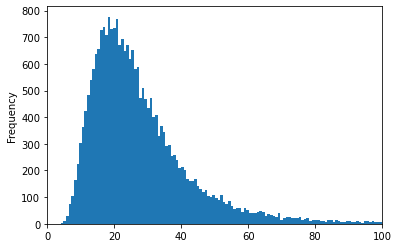

In [9]:
# df['p(t|s)'].plot(kind='bar', xlim=(0.0, 0.81))

df['src_ppl'].plot(kind='hist', bins=500, xlim=(0.0, 100))


<AxesSubplot:ylabel='Frequency'>

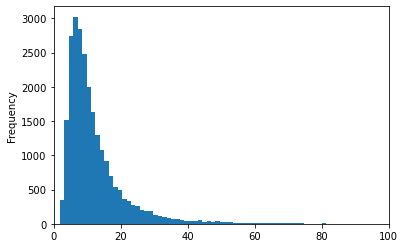

In [16]:
# df['p(s|t)'].plot(kind='kde', xlim=(0.0, 0.81))

df['tgt_ppl'].plot(kind='hist', bins=500, xlim=(0.0, 100))


/mnt/storage/clwork/users/kew/INSTALLS/anaconda3/envs/readvisor38/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


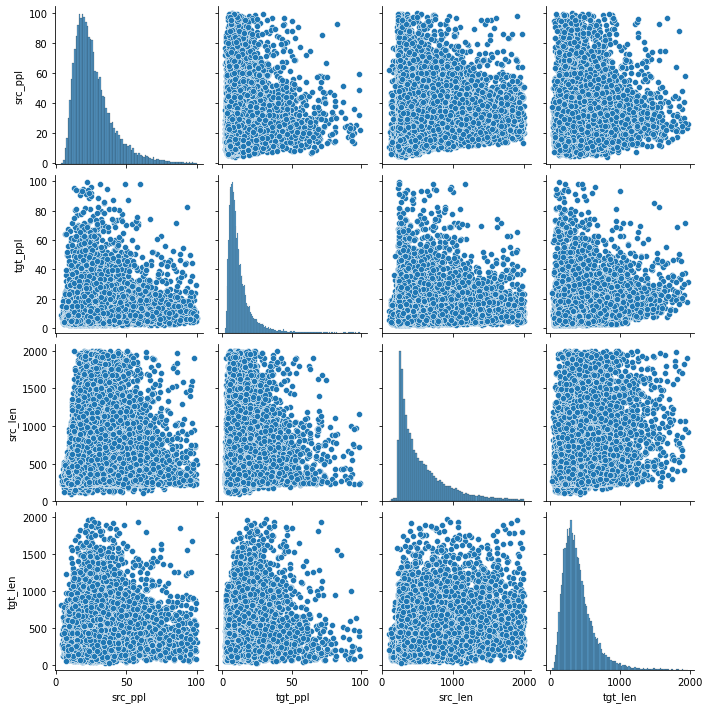

In [11]:
# Create the default pairplot
# remove outliers

dfv = df[(df['tgt_len'] < 2000) & (df['src_len'] < 2000) & (df['src_ppl'] < 100) & (df['tgt_ppl'] < 100)]
dfv.drop(columns='score_diff', inplace=True)
sns.pairplot(dfv)

In [17]:
print(df['tgt_ppl'].describe())
print(df['src_ppl'].describe())

count    24651.000000
mean        12.522274
std         13.585091
min          1.851350
25%          6.519765
50%          9.446050
75%         14.506935
max        665.393190
Name: tgt_ppl, dtype: float64
count    24651.000000
mean        28.294015
std         17.707604
min          4.033820
25%         17.403520
50%         24.184450
75%         33.866665
max        394.298980
Name: src_ppl, dtype: float64


In [22]:
print(len(df))
df_filt = df[(df['tgt_ppl'] > 9) & (df['tgt_ppl'] < 15)]
print(len(df_filt))
df_filt.sample(n=10)

24651
7341


,src_ppl,tgt_ppl,src,tgt,src_len,tgt_len,score_diff
22025,15.05284,9.67562,"Historic, comfortable, friendly ---SEP--- It has been a few years since I was last at the Grace. It is still as charming as I remembered. My room was very large, king size bed, very nice toiletries ( with toothbrush). Had lunch at the brasserie. Good selection of salads and hot food.","Dear agltay, Welcome back to the Grace Hotel, Sydney! We are glad you still enjoyed your stay with us and after a few years we are still able to ""charm"" your stay. Thank you for choosing to return to stay with us and providing us your valuable feedback on TripAdvisor. Hopefully we will be able to see you again soon. Kind regards, Christina Mendieta",284,350,-5.37722
6225,14.04949,9.15564,"Perfect location for the city ---SEP--- We stayed at the Maldron Hotel from 12th to the 15th July 2013. The location of the hotel is ideal if you are travelling to Cardiff by train and very convenient for the shopping centre, castle and museums. I have read on here some people complaining about noise from either the railway tracks or the busy bars nearby, we were on the 7th floor and were not disturbed by either and, indeed, considering the size of the hotel found it very quiet. The rooms are nicely presented and include tea and coffee making facilities as well as toiletries, a proper full-sized hairdryer and tv. The staff on the reception desk were all very welcoming and helpful and the housekeeping staff we saw about the hotel were also very pleasant. We did not eat at the hotel as I thought £9.00 each for breakfast was a bit steep, especially with the wide choice available in the city being so close. Overall, excellent value for money and I would definately stay here again.","Dear huwsus, I appreciate you taking the time to share your comments on tripadvisor. I am delighted you enjoyed your stay overall. As a city centre hotel our breakfast is priced in line with other hotels in the area, we believe our breakfast is competitively priced in this segment when compared to other hotel brands. However due to our location there are many options for guests to consider. I hope you will consider staying with us in the future. Kind Regards, Alison Mansfield Deputy General Manager",991,503,-4.89385
18530,25.36394,11.07219,"An overnight stay at Combe Grove Hotel. ---SEP--- Amazing surroundings, a beautiful house, attentive staff, and great food - just brace yourself for the price of soft drinks! There are other facilities available which I didn't try (spa, swimming pool, etc.) but just a walk through the grounds will make you feel better.","Hi Steve W Thank you for your review. It is wonderful to read that you enjoyed your time here and I'm happy you were able to do a bit of exploring. Your comment on the soft drinks is noted, and we are reviewing what we offer in the bar in the coming months, so if you do return you might find you are pleased with the changes. All the best, Sharon Love General Manager",320,368,-14.29175
3311,39.93438,10.95784,Worth a visit ---SEP--- Overall very nice room was a bit noisey from outside cleaning Food was good and a good mix from the menu Didn't use the spa facilities but looked very well allocated Room very comfortable and had everything required.,"Dear Andrewhowlin Thank you for taking the time to review our hotel, I am so pleased you had an enjoyable visit. Hope to see you again soon, Luke and team at FBH",240,161,-28.97654
20064,35.76166,13.51386,"A little better this time.... ---SEP--- Second time here, second time disappointed... Valet folks are friendly and quick as could be, kudos to you. Check-in was fairly quick and lobby was very appealing to the eye as you walk past the hotel bar and lobby seating that opens up the pool. Sitting outside on the balcony at night with the island breeze was nice and relaxing...especially after a long day at work. Housekeeping was very friendly and detail oriented on the days I requested my room to be cleaned. That's why 

In [13]:
# print(len(df))
# df[df['tgt_ppl'] < 4].sample(n=10)
# print(len(df_filt))
# df_filt = df_filt[df_filt['tgt_ppl'] < 100]
# print(len(df_filt))
# df_filt.sort_values(by=['tgt_ppl'], ascending=True)

In [14]:
# print(len(df))
# df_filt = df[df['tgt_ent'] > 3.5]
# print(len(df_filt))
# df_filt.sort_values(by=['tgt_ent'], ascending=True)

In [15]:
# sns.pairplot(df_filt[df_filt.tgt_len < 2000])